<h3>TODO</h3> 
Fill in any place that says <code># YOUR CODE HERE</code> (make sure to remove the line <code>raise NotImplementedError()</code>).

<h3>Suggestions</h3>

- To speed up your code, think about how certain operations can be done at the same time.
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- Double check your code does not have $\infty$-loops, these will crash the autograder.

<h3>Rules</h3>

- Blank cells in the notebook are hidden tests. **Do not delete, copy, paste, or alter these cells as this will cause the tests to fail automatically**.
- Do not create multiple python notebooks (.ipynb files).
- Do not import any new python packages (this may cause hidden tests to fail).
- Each cell must run for less than 5 minutes (there exists a solution with full marks).
- **Do not plagiarise!** We take violations of this very seriously. In previous years we have identified instances of plagiarism and reported them to the Senior Teaching & Learning Administrator.
- If you are happy with your current grade you do not need to resubmit, the most recent grade from the autograder will be your final grade.

---

<h2>Coursework 1 - Decision Trees</h2>


<!--announcements-->
<blockquote>
    <center>
    <img src="forest.jpg" width="400px" />
    </center>
      <p><cite><center>Boosting took a long time to be truly understood.<br>
      ... cynics say we didn't see the forest for all the trees ...<br>
      </center></cite></p>
</blockquote>

<!--announcements-->






<h3>Introduction</h3>
<p>In this assignment you will implement a decision tree algorithm and then use it for bagging and boosting. We've provided a tree structure for you with distinct leaves and nodes. Leaves have two fields, parent (another node) and prediction (a numerical value). Nodes have six fields: 

<ol>
<li> <b>left</b>: node describing left subtree </li>
<li> <b>right</b>: node describing right subtree </li>
<li> <b>parent</b>: the parent of the current subtree. The head of the tree always has <code><b>None</b></code> as its parent. Feel free to initialize nodes with this field set to <code><b>None</b></code> so long as you set the correct parent later on. </li>
<li> <b>cutoff_id</b>: index of feature to cut </li>
<li> <b>cutoff_val</b>: cutoff value c (<=c : left, and >c : right)</li>
<li> <b>prediction</b>: scalar prediction at this node. <b>(NOTE: please do not check if a node is a leaf by checking for prediction=None, this will mess up autograder tests!)</b>  </li>
</ol>
</p>


        

In [1]:
class TreeNode(object):
    """Tree class.
    
    (You don't need to add any methods or fields here but feel
    free to if you like. Our tests will only reference the fields
    defined in the constructor below, so be sure to set these
    correctly!)
    """
    
    def __init__(self, left, right, parent, cutoff_id, cutoff_val, prediction):
        self.left = left
        self.right = right
        self.parent = parent
        self.cutoff_id = cutoff_id
        self.cutoff_val = cutoff_val
        self.prediction = prediction

<h3>Implementing CART</h3>
Before we get started let us add a few packages that you might need. We will also load a data set <a href="https://archive.ics.uci.edu/ml/datasets/Ionosphere">ION</a>, which we will use as our binary test classification problem.

In [2]:
%matplotlib widget
import numpy as np
import math
from numpy.matlib import repmat
import sys
import matplotlib 
import matplotlib.pyplot as plt
from scipy.io import loadmat
import time
import os
import warnings
sys.path.append('')
warnings.filterwarnings("ignore", category=DeprecationWarning) 


# load in some binary test data (labels are -1, +1)
data = loadmat("ion.mat")
xTrIon  = data['xTr'].T
yTrIon  = data['yTr'].flatten()
xTeIon  = data['xTe'].T
yTeIon  = data['yTe'].flatten()

xTrIon.shape, yTrIon.shape, xTeIon.shape, yTeIon.shape

((281, 34), (281,), (70, 34), (70,))

In [3]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

xTrSpiral,yTrSpiral,xTeSpiral,yTeSpiral=spiraldata(150)

<h3> Efficiently implementing regression trees </h3>
<p>First, implement the function <code>sqsplit</code> which takes as input a (weighted) data set with labels and computes the best feature and cut-value of an optimal split based on minimum squared error. The third input is a weight vector which assigns a positive weight to each training sample. The loss you should minimize is the averaged weighted squared-loss:
$$
	{\cal L}(S)=\sum_{i \in L} {w_{i}(y_{i} - T_{L})}^2+\sum_{i \in R} {w_{i}(y_{i} - T_{R})}^2. %\label{q2:loss}
$$
</p>
You are building a regression tree, and right now you need to choose a split for the given dataset $S=\{(\vec x_1,y_1),\dots,(\vec x_n,y_n)\}$ (where we have continuous labels $y_i\in{\cal R}$).
Suppose you split on some feature $j$ with value $c$ and partition the dataset in to two sets of indices, $L$--the set of indices on the left (i.e., $i \in L \Rightarrow [x_{i}]_{j} < c$)--and $R$--the set of indices on the right (i.e., $i \in R \Rightarrow [x_{i}]_{j} > c$). Suppose you assign every data point on the left the prediction $T_{L}$ and every data point on the right the prediction $T_{R}$. Finally, suppose that each data point $x_{i}$ has an associated weight $w_{i}$, and that the weights are normalized (i.e., $\sum_{i} w_{i} = 1$). 


<p> First, we show that setting $T_{L}$ and $T_{R}$ to the weighted average label over their respective sets (i.e., $T_{L} = \frac{1}{W_{L}}\sum_{i\in L}w_{i}y_{i}$ and $T_{R} = \frac{1}{W_{R}}\sum_{i\in R}w_{i}y_{i}$) minimizes the loss $\cal L$, where $W_{L}=\sum_{i \in L}w_{i}$ and $W_{R}=\sum_{i \in R} w_{i}$ are the total weight of the left and right side respectively.

<p> We take the derivative of the loss with respect to $T_{L}$ to obtain $$\frac{d}{dT_{L}} {\cal L}(S) = -2\sum_{i \in L}w_{i}(y_i - T_L)=-2\sum_{i\in L}w_iy_i + 2T_{L}\sum_{i}w_{i}$$ Setting this equal to zero and solving, we get $$2T_{L}w_{L}=2\sum_{i \in L}w_{i}y_{i}$$ and therefore $$T_{L} = \frac{1}{W_{L}}\sum_{i \in L}w_{i}y_{i}$$ A symmetric argument holds for $T_{R}$.</p>

<p> Now, imagine you are considering splitting on some feature $j$, and suppose you have already sorted the training points in the order of this feature value, so that $[x_{1}]_{j} < [x_{2}]_{j} < \cdots < [x_{n}]_{j}$. You'd like to choose a split from among $c_{1} \leq c_{2} \leq \cdots \leq c_{n-1}$, where $c_{i}=\frac{[x_{i}]_{j}+[x_{i+1}]_{j}}{2}$. One way to do this would be to, for each possible split $c_{k}$, decide whether each $x_{i}$ should be partitioned left or right, and compute $\cal L$. At the end, take the split with the lowest loss. The number of data points $n$ and there are $O(n)$ splits to consider, and the proposed algorithm would require $O(n)$ per split to evaluate $\cal L$, for a total of $O(n^2)$ time.

<p> Now, suppose some split $c_{k}$ results in the data being partitioned in to $L^{(k)}$ and $R^{(k)}$. Suppose you are given the following quantities precomputed: $W_{L^{(k)}}$, $P_{L^{(k)}} = \sum_{i \in L} w_{i}y_{i}$, and $Q_{L^{(k)}} = \sum_{i \in L} w_{i}y_{i}^{2}$. Similarly, you are given $W_{R^{(k)}}$, $P_{R^{(k)}}$ and $Q_{R^{(k)}}$ Equipped with these precomputed quantities, we can compute $\cal L$ in constant time:

<p>Expand the left side of the loss to $$\sum_{i \in L}w_{i}y_{i}^{2} - 2\sum_{i \in L}w_{i}y_{i}T_{L} + \sum_{i \in L}w_{i}T_{L}^{2}$$. The first term is exactly $Q_{L^{(k)}}$. The second term can be written as $-2P_{L^{(k)}}\frac{P_{L^{(k)}}}{W_{L^{(k)}}}=-2\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}}$. The last term can be written as $w_{L^{(k)}}\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}^{2}}=\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}}$. The second term plus the third term is therefore simply $-\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}}$. Therefore the whole expression can be evaluated as: $$Q_{L^{(k)}}-\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}}$$ Similarly, the right term is: $$Q_{R^{(k)}}-\frac{P_{R^{(k)}}^{2}}{w_{R^{(k)}}}$$</p>

<p> <b> Efficent Update Rule: </b> If all feature values are distinct, only one data point moves from $R$ to $L$ when moving from split $k$ to split $k+1$. Therefore, we simply update the values accordingly. For example, we subtract $w_{k}$ from $W_{R^{(k)}}$ and add it to $W_{L^{(k)}}$. We subtract $w_{k}y_{k}$ from $P_{R^{(k)}}$ and add it to $P_{L^{(k)}}$. We subtract $w_{k}y_{k}^{2}$ from $Q_{R^{(k)}}$ and add it to $Q_{L^{(k)}}$. Crucially, all of these updates take only constant time. </p>

In [4]:
def sqsplit(xTr,yTr,weights=None):
    """Finds the best feature, cut value, and loss value.
    Input:
        xTr:     n x d matrix of data points
        yTr:     n-dimensional vector of labels
        weights: n-dimensional weight vector for data points
    Output:
        feature:  index of the best cut's feature
        cut:      cut-value of the best cut
        bestloss: loss of the best cut
    """
    N,D = xTr.shape
    assert D > 0 # must have at least one dimension
    assert N > 1 # must have at least two samples
    if weights is None: # if no weights are passed on, assign uniform weights
        weights = np.ones(N)
    weights = weights/sum(weights) # Weights need to sum to one (we just normalize them)
    bestloss = np.inf
    feature = np.inf
    cut = np.inf
    # YOUR CODE HERE
    # raise NotImplementedError()
    wy = weights*yTr
    wyy = wy*yTr
    W = sum(weights)
    P = sum(wy)
    Q = sum(wyy)

    for fcol in range(D): # each feature column

        sorted_i = np.argsort(xTr[:, fcol])
        sorted_xTr = xTr[sorted_i, :]
        sorted_yTr = yTr[sorted_i]
        sorted_w = weights[sorted_i]

        w_k = sorted_w[0]
        y_k = sorted_yTr[0]
        
        wl = sorted_w[0]
        wr = W - wl

        pl = w_k * y_k
        pr = P - pl

        ql = w_k * y_k ** 2
        qr = Q - ql

        for row in range(1, N):
            
            if sorted_xTr[row, fcol] != sorted_xTr[row - 1, fcol] and wl != 0 and wr != 0:
            
                loss_l = (ql - (pl ** 2)/wl)
                loss_r = (qr - (pr ** 2)/wr)
    
                loss = loss_l + loss_r
        
                if loss < bestloss:
                    bestloss = loss
                    feature = fcol
                    cut = (sorted_xTr[row, fcol] + sorted_xTr[row - 1, fcol]) / 2
            
            w_k = sorted_w[row]
            y_k = sorted_yTr[row]

            wl += w_k
            wr -= w_k
            
            pl += w_k * y_k
            pr -= w_k * y_k
            
            ql += w_k * y_k ** 2
            qr -= w_k * y_k ** 2
                    
    return feature, cut, bestloss

In [5]:
t0 = time.time()
fid,cut,loss = sqsplit(xTrIon,yTrIon)
t1 = time.time()
print('elapsed time:',t1-t0,'seconds')
print("Split on feature %i on value: %2.3f" % (fid,cut))
print("NOTE: It should split on feature 2 on value 0.304")

elapsed time: 0.043126821517944336 seconds
Split on feature 2 on value: 0.304
NOTE: It should split on feature 2 on value 0.304


<h2>Testing Your Code</h2>

<p>As your code will be tested by an autograder, <b>we highly recommend you test all of the code you implement</b> to make sure it works as you expect in both normal and abnormal use-cases. Below shows an example test for the sqsplit function. </p>

In [6]:
# an example test
xor = np.array([[1, 1, 1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 1, 1, 0, 0],
                 [1, 0, 1, 0, 1, 0, 1, 0]]).T
yor = np.array( [1, 0, 0, 1, 0, 1, 1, 0])
b = np.isclose(sqsplit(xor,yor)[2], .25)
print('Function sqsplit correctly calculates bestloss on xor/yor example: ' + str(b))

Function sqsplit correctly calculates bestloss on xor/yor example: True


In [7]:
# Do not delete, copy, paste, or alter these cells as this will cause the tests to fail automatically

<b>Cart tree:</b><p>Implement the function <code>cart</code> which returns a regression tree based on the minimum squared loss splitting rule. The function takes training data, test data, a maximum depth, and the weigh of each training example. Maximum depth and weight are optional arguments. If they are not provided you should make maximum depth infinity and equally weight each example. You should use the function <code>sqsplit</code> to make your splits.</p>

<p>Use the provided <code>TreeNode</code> class to represent your tree. Note that the nature of CART trees implies that every node has exactly 0 or 2 children.</p>


In [46]:
def cart(xTr,yTr,depth=np.inf,weights=None):
    """Builds a CART tree.
    
    The maximum tree depth is defined by "maxdepth" (maxdepth=2 means one split).
    Each example can be weighted with "weights".

    Args:
        xTr:      n x d matrix of data
        yTr:      n-dimensional vector
        maxdepth: maximum tree depth
        weights:  n-dimensional weight vector for data points

    Returns:
        tree: root of decision tree
    """
    n,d = xTr.shape
    if weights is None:
        w = np.ones(n) / float(n)
    else:
        w = weights
    
    # YOUR CODE HERE
    # raise NotImplementedError()

    tree = None

    prediction = np.dot(w, yTr) / np.sum(w)

    if depth == 0 or np.unique(yTr).size==1: #  n <=2 ???? or d <= 1: ????
        return TreeNode(None, None, None, None, None, prediction)

    feature, cut, loss = sqsplit(xTr, yTr, w)

    if feature == np.inf: 
        return TreeNode(None, None, None, None, None, prediction)
            
    l_i = xTr[:,feature] <= cut
    # print(l_i)
    r_i = xTr[:,feature] > cut

    # if not np.any(l_i) or not np.any(r_i):
    #     return TreeNode(None, None, None, None, None, prediction)

    xl = xTr[l_i,:]
    # print(xl)
    yl = yTr[l_i]
    wl = w[l_i] # if weights is not None else None

    xr = xTr[r_i,:]
    yr = yTr[r_i]
    wr = w[r_i] # if weights is not None else None

    left_s = cart(xl, yl, depth - 1, wl) # if np.any(l_i) else None
    right_s = cart(xr, yr, depth - 1, wr) # if np.any(r_i) else None

    tree = TreeNode(left_s, right_s, None, feature, cut, None)
    if left_s is not None:
        left_s.parent = tree
    if right_s is not None:
        right_s.parent = tree
    # tree.prediction = (left_s.prediction + right_s.prediction)/2
    

    return tree

<p>Implement the function <code>evaltree</code>, which evaluates a decision tree on a given test data set.</p>

In [47]:
# YOUR CODE HERE
# raise NotImplementedError()
           
def evaltree(root,xTe):
    """Evaluates xTe using decision tree root.
    
    Input:
        root: TreeNode decision tree
        xTe:  n x d matrix of data points
    
    Output:
        pred: n-dimensional vector of predictions
    """
    assert root is not None
    
    # YOUR CODE HERE
    # raise NotImplementedError()

    n,d = xTe.shape
    pred = np.zeros(n)

    for i in range(n):
        myroot = root
        while True:
            if myroot.cutoff_id is None:
                pred[i] = myroot.prediction
                break
            elif xTe[i, myroot.cutoff_id] <= myroot.cutoff_val:
                myroot = myroot.left
            else:
                myroot = myroot.right
                
    return pred

<p>In the below test you should see an output very similar to the following: 

<code>elapsed time: 0.65 seconds
Training RMSE : 0.00
Testing  RMSE : 0.69
</code>

(<code>elapsed time</code> will be slightly different)
</p>

In [48]:
t0 = time.time()
root = cart(xTrIon, yTrIon)
t1 = time.time()

tr_err   = np.mean((evaltree(root,xTrIon) - yTrIon)**2)
te_err   = np.mean((evaltree(root,xTeIon) - yTeIon)**2)

print("elapsed time: %.2f seconds" % (t1-t0))
print("Training RMSE : %.2f" % tr_err)
print("Testing  RMSE : %.2f" % te_err)

elapsed time: 0.20 seconds
Training RMSE : 0.00
Testing  RMSE : 0.69


<p>The following code defines a function <code>visclassifier()</code>, which plots the decision boundary of a classifier in 2 dimensions. Execute the following code to see what the decision boundary of your tree looks like on the ion data set. </p>

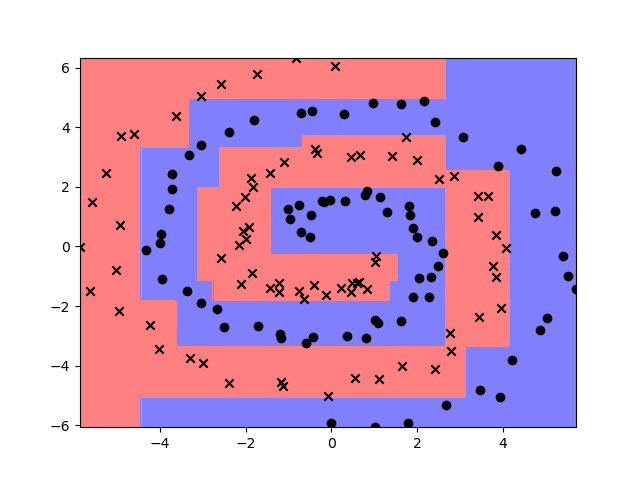

Training error: 0.0000
Testing error:  0.0133
NOTE: You should get something similar to:
Training error: 0.0000
Testing error:  0.0467 (may be slightly different)


In [11]:
def visclassifier(fun,xTr,yTr,w=None,b=0):
    """
    visualize decision boundary
    Define the symbols and colors we'll use in the plots later
    """

    yTr = np.array(yTr).flatten()
    w = np.array(w).flatten()

    symbols = ["ko","kx"]
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    # get the unique values from labels array
    classvals = np.unique(yTr)

    plt.figure()

    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(min(xTr[:, 0]), max(xTr[:, 0]),res)
    yrange = np.linspace(min(xTr[:, 1]), max(xTr[:, 1]),res)
    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    
    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # test all of these points on the grid
    testpreds = fun(xTe)
    
    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)

    # creates x's and o's for training set
    for idx, c in enumerate(classvals):
        plt.scatter(xTr[yTr == c,0],
            xTr[yTr == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    
    if w != []:
        alpha = -1 * b / (w ** 2).sum()
        plt.quiver(w[0] * alpha, w[1] * alpha,
            w[0], w[1], linewidth=2, color=[0,1,0])

    plt.axis('tight')
    # shows figure and blocks
    plt.show()

tree=cart(xTrSpiral,yTrSpiral) # compute tree on training data 
visclassifier(lambda X:evaltree(tree,X),xTrSpiral,yTrSpiral)
print("Training error: %.4f" % np.mean(np.sign(evaltree(tree,xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(evaltree(tree,xTeSpiral)) != yTeSpiral))
print("NOTE: You should get something similar to:")
print("Training error: 0.0000")
print("Testing error:  0.0467 (may be slightly different)")

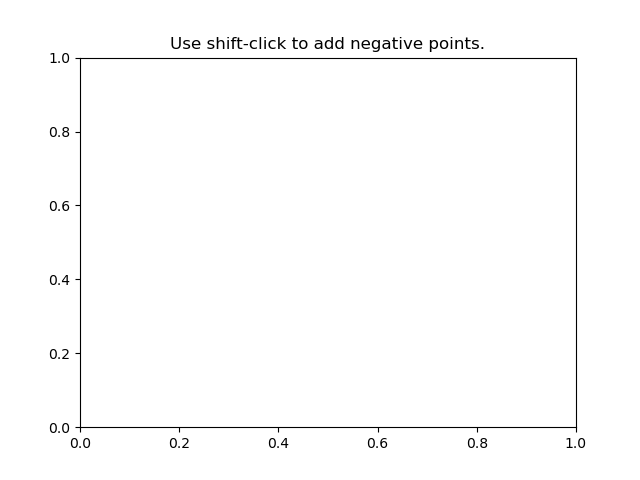

In [12]:
def onclick_cart(event):
    """
    Visualize cart, including new point
    """
    global xTraining,labels
    # create position vector for new point
    pos=np.array([[event.xdata,event.ydata]]) 
    if event.key == 'shift': # add positive point
        color='or'
        label=1
    else: # add negative point
        color='ob'
        label=-1    
    xTraining = np.concatenate((xTraining,pos), axis = 0)
    labels.append(label);
    marker_symbols = ['o', 'x']
    classvals = np.unique(labels)
        
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    
    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(0, 1,res)
    yrange = np.linspace(0, 1,res)

    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # get decision tree
    tree=cart(xTraining,np.array(labels).flatten())
    fun = lambda X:evaltree(tree,X)
    # test all of these points on the grid
    testpreds = fun(xTe)
    
    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    
    plt.cla()    
    plt.xlim((0,1))
    plt.ylim((0,1))
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)
    
    for idx, c in enumerate(classvals):
        plt.scatter(xTraining[labels == c,0],
            xTraining[labels == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    plt.show()
    
plt.ion()
xTraining= np.array([[5,6]])
labels = [1]
fig = plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Use shift-click to add negative points.')
# plt.connect('button_press_event', onclick_cart)
cid = fig.canvas.mpl_connect('button_press_event', onclick_cart)
plt.show()

<h2>Random Forests</h2>
<p>CART trees are known to be high variance classifiers
(if trained to full depth).
An effective way to prevent overfitting is to use <b>Bagging</b>.
Implement the function <code>forest</code>,
which builds a forest of regression trees.
Each tree should be built using training data
drawn by randomly sampling $n$ examples
from the training data with replacement.
Do not randomly sample features.
The function should output a list of trees.</p>

In [13]:
def forest(xTr, yTr, m, maxdepth=np.inf):
    """Creates a random forest.
    
    Input:
        xTr:      n x d matrix of data points
        yTr:      n-dimensional vector of labels
        m:        number of trees in the forest
        maxdepth: maximum depth of tree
        
    Output:
        trees: list of TreeNode decision trees of length m
    """
    
    n, d = xTr.shape
    trees = []
    
    # YOUR CODE HERE
    # raise NotImplementedError()

    for i in range(m):
        
        r_i = np.random.choice(n, n, replace = True) # check if replace is needed or default

        xTr_m = xTr[r_i,:]
        yTr_m = yTr[r_i]

        # def cart(xTr,yTr,depth=np.inf,weights=None): check if works for maxdepth=30
        tree = cart(xTr_m, yTr_m, depth=maxdepth, weights=None)
        trees.append(tree)
        
    
    return trees

<p>Now implement the function <code>evalforest</code>, which should take as input a set of $m$ trees, a set of $n$ test inputs, and an $m$ dimensional weight vector. Each tree should be weighted by the corresponding weight. (For random forests you can define the weights to be $\frac{1}{m}$ for all trees.</p>

In [14]:
def evalforest(trees, X, alphas=None):
    """Evaluates X using trees.
    
    Input:
        trees:  list of TreeNode decision trees of length m
        X:      n x d matrix of data points
        alphas: m-dimensional weight vector
        
    Output:
        pred: n-dimensional vector of predictions
    """
    m = len(trees)
    n,d = X.shape
    if alphas is None:
        alphas = np.ones(m) / len(trees)
            
    pred = np.zeros(n)

    for i in range(m):
        pred += evaltree(trees[i], X) * alphas[i]
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    return pred

<p>The following script visualizes the decision boundary of a random forest ensemble.</p>

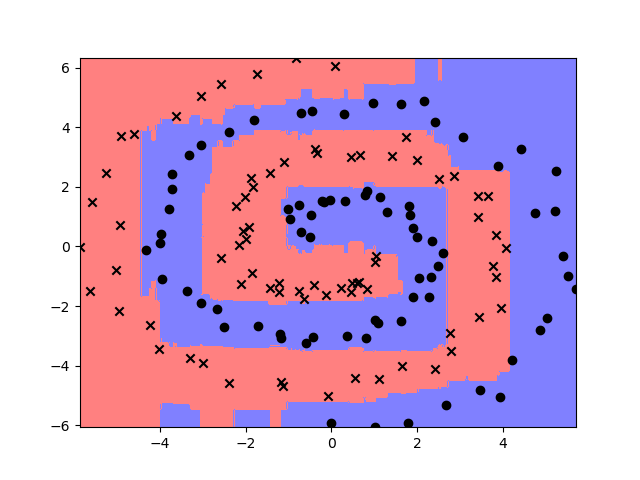

Training error: 0.0000
Testing error:  0.0200


In [15]:
trees=forest(xTrSpiral,yTrSpiral,30) # compute tree on training data 
visclassifier(lambda X:evalforest(trees,X),xTrSpiral,yTrSpiral)
print("Training error: %.4f" % np.mean(np.sign(evalforest(trees,xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(evalforest(trees,xTeSpiral)) != yTeSpiral))

<p>The following script evaluates the test and training error of a random forest ensemble as we vary the number of trees.</p>

[0]training err = 0.0854	testing err = 0.1286
[1]training err = 0.0712	testing err = 0.1429
[2]training err = 0.0214	testing err = 0.1000
[3]training err = 0.0214	testing err = 0.1000
[4]training err = 0.0036	testing err = 0.1000
[5]training err = 0.0036	testing err = 0.1000
[6]training err = 0.0036	testing err = 0.0857
[7]training err = 0.0071	testing err = 0.0857
[8]training err = 0.0036	testing err = 0.0714
[9]training err = 0.0036	testing err = 0.0857
[10]training err = 0.0036	testing err = 0.0857
[11]training err = 0.0036	testing err = 0.1000
[12]training err = 0.0036	testing err = 0.1143
[13]training err = 0.0000	testing err = 0.1143
[14]training err = 0.0000	testing err = 0.1000
[15]training err = 0.0000	testing err = 0.1286
[16]training err = 0.0000	testing err = 0.0857
[17]training err = 0.0000	testing err = 0.0857
[18]training err = 0.0000	testing err = 0.0857
[19]training err = 0.0000	testing err = 0.0714


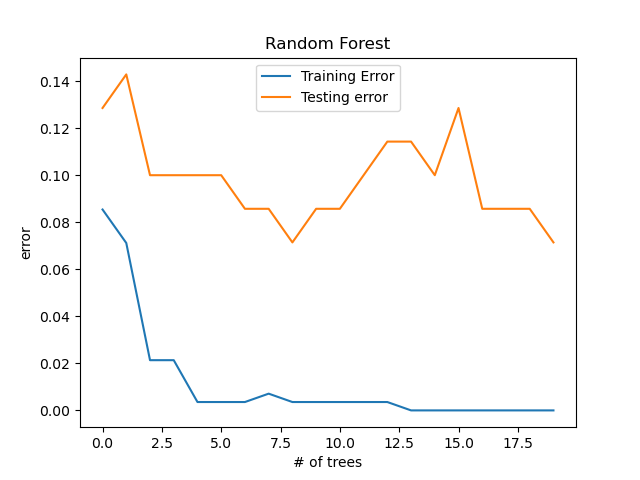

In [16]:
M=20 # max number of trees
err_trB=[]
err_teB=[]
alltrees=forest(xTrIon,yTrIon,M)
for i in range(M):
    trees=alltrees[:i+1]
    trErr = np.mean(np.sign(evalforest(trees,xTrIon)) != yTrIon)
    teErr = np.mean(np.sign(evalforest(trees,xTeIon)) != yTeIon)
    err_trB.append(trErr)
    err_teB.append(teErr)
    print("[%d]training err = %.4f\ttesting err = %.4f" % (i,trErr, teErr))

plt.figure()
line_tr, = plt.plot(range(M),err_trB,label="Training Error")
line_te, = plt.plot(range(M),err_teB,label="Testing error")
plt.title("Random Forest")
plt.legend(handles=[line_tr, line_te])
plt.xlabel("# of trees")
plt.ylabel("error")
plt.show()
# Your training error should converge

Note: there is strong delay between points


Text(0.5, 1.0, 'Use shift-click to add negative points.')

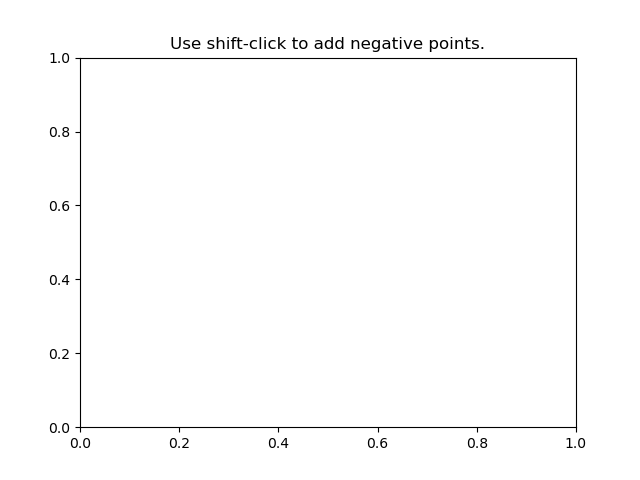

In [17]:
def onclick_forest(event):
    """
    Visualize forest, including new point
    """
    global xTrain,yTrain,w,b,M
    # create position vector for new point
    pos=np.array([[event.xdata,event.ydata]]) 
    if event.key == 'shift': # add positive point
        color='or'
        label=1
    else: # add negative point
        color='ob'
        label=-1    
    xTrain = np.concatenate((xTrain,pos), axis = 0)
    yTrain = np.append(yTrain, label)
    marker_symbols = ['o', 'x']
    classvals = np.unique(yTrain)
        
    w = np.array(w).flatten()
    
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    
    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(0, 1,res)
    yrange = np.linspace(0, 1,res)
    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # get forest
    trees=forest(xTrain,yTrain,M)
    fun = lambda X:evalforest(trees,X)
    # test all of these points on the grid
    testpreds = fun(xTe)
    
    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    
    plt.cla()    
    plt.xlim((0,1))
    plt.ylim((0,1))
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)
    
    for idx, c in enumerate(classvals):
        plt.scatter(xTrain[yTrain == c,0],
            xTrain[yTrain == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    plt.show()
    
        
xTrain= np.array([[5,6]])
b=yTrIon
yTrain = np.array([1])
w=xTrIon
M=20

fig = plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)
cid = fig.canvas.mpl_connect('button_press_event', onclick_forest)
print('Note: there is strong delay between points')
plt.title('Use shift-click to add negative points.')

<h2>Boosting</h2>

<p>Another option to improve your decision trees is to build trees of small depth (e.g. only depth=3 or depth=4). These do not have high variance, but instead suffer from <b>high bias</b>. You can reduce the bias of a classifier with boosting. Implement the function <code>boosttree</code>, which applies Adaboost on your <code>cart</code> functions. You should be able to use the function <code>evalforest</code> to evaluate your boosted ensemble (provdided you pass on the weights correctly.)</p>

In [18]:
def get_alpha(er):
    a = 0.5 * np.log((1-er)/er)
    return a

def min_er(preds, y, w):
    return np.multiply(np.where(np.sign(preds) != y, 1, 0), w).sum()
    
def boosttree(x,y,maxiter=100,maxdepth=2):
    """Learns a boosted decision tree.
    
    Input:
        x:        n x d matrix of data points
        y:        n-dimensional vector of labels
        maxiter:  maximum number of trees
        maxdepth: maximum depth of a tree
        
    Output:
        forest: list of TreeNode decision trees of length m
        alphas: m-dimensional weight vector
        
    (note, m is at most maxiter, but may be smaller,
    as dictated by the Adaboost algorithm)
    """
    assert np.allclose(np.unique(y), np.array([-1,1])); # the labels must be -1 and 1 
    n,d = x.shape
    weights = np.ones(n) / n
    preds   = None
    forest  = []
    alphas  = []
    # print(weights)

    # YOUR CODE HERE
    # raise NotImplementedError()
    er = 0

    for i in range(0, maxiter): # change m to ?
        # create a weak learner h with cart(xtr, ytr, depth, weights)
        tree = cart(x, y, maxdepth, weights)
        # find predictions evaltree
        preds = evaltree(tree, x)
        # define er
        er = min_er(preds, y, weights)
        # print(er)
        if er < 0.5:
            a = get_alpha(er)
            alphas.append(a)
            forest.append(tree)
            # print(a, preds)
            w_t = np.multiply(weights, np.exp((-1) * a * preds * y))
            w_div = 2 * np.sqrt(er*(1 - er))
            weights = np.divide(w_t, w_div)
            # print(weights)
            # update weights
        else:
            break
            
      
    
    
    return forest, alphas

<p>The following script evaluates the test and training error of a boosted forest as we increase the number of trees.</p>

[0] exp loss = 0.4630 training err = 0.0676	testing err = 0.1429
[1] exp loss = 0.2723 training err = 0.0534	testing err = 0.2000
[2] exp loss = 0.1297 training err = 0.0107	testing err = 0.1714
[3] exp loss = 0.0804 training err = 0.0036	testing err = 0.1571
[4] exp loss = 0.0479 training err = 0.0000	testing err = 0.1286
[5] exp loss = 0.0265 training err = 0.0000	testing err = 0.1143
[6] exp loss = 0.0149 training err = 0.0000	testing err = 0.1143
[7] exp loss = 0.0090 training err = 0.0000	testing err = 0.1571
[8] exp loss = 0.0057 training err = 0.0000	testing err = 0.1286
[9] exp loss = 0.0029 training err = 0.0000	testing err = 0.1286
[10] exp loss = 0.0016 training err = 0.0000	testing err = 0.1286
[11] exp loss = 0.0011 training err = 0.0000	testing err = 0.1143
[12] exp loss = 0.0006 training err = 0.0000	testing err = 0.1286
[13] exp loss = 0.0004 training err = 0.0000	testing err = 0.1429
[14] exp loss = 0.0002 training err = 0.0000	testing err = 0.1143
[15] exp loss = 0.00

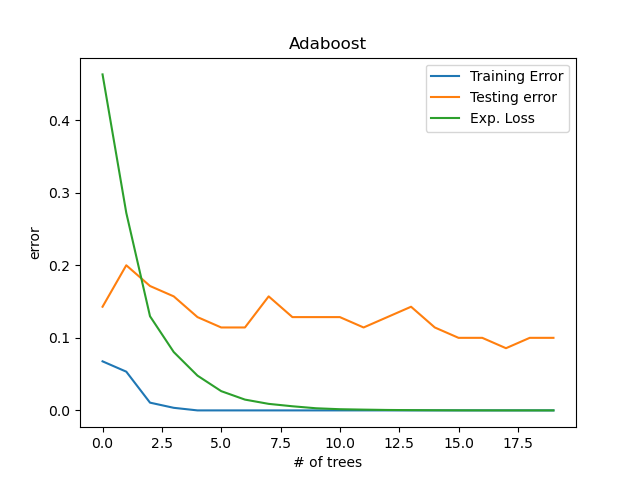

In [19]:
M=20 # max number of trees
alltrees,allalphas=boosttree(xTrIon,yTrIon,maxdepth=3,maxiter=M)

err_trB=[]
loss_trB=[]
err_teB=[]
for i in range(M):
    trees=alltrees[:i+1]
    alphas=allalphas[:i+1]
    trErr = np.mean(np.sign(evalforest(trees,xTrIon,alphas)) != yTrIon)
    trLoss =np.mean(np.exp(-evalforest(trees,xTrIon,alphas)*yTrIon))
    teErr = np.mean(np.sign(evalforest(trees,xTeIon,alphas)) != yTeIon)
    err_trB.append(trErr)
    err_teB.append(teErr)
    loss_trB.append(trLoss)
    print("[%d] exp loss = %.4f training err = %.4f\ttesting err = %.4f" % (i,trLoss,trErr, teErr))

plt.figure()
line_tr, = plt.plot(range(M),err_trB,label="Training Error")
line_te, = plt.plot(range(M),err_teB,label="Testing error")
line_trloss,=plt.plot(range(M),loss_trB,label='Exp. Loss')
plt.title("Adaboost")
plt.legend(handles=[line_tr, line_te,line_trloss])
plt.xlabel("# of trees")
plt.ylabel("error")
plt.show()
# Your training error should converge very quickly

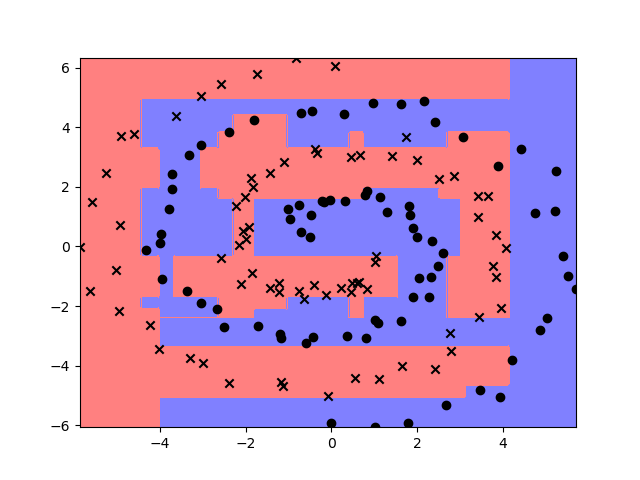

elapsed time: 0.21 seconds
Training error: 0.0533
Testing error:  0.1467


In [20]:
trees,alphas=boosttree(xTrSpiral,yTrSpiral,maxdepth=3,maxiter=20)
visclassifier(lambda X:evalforest(trees,X,alphas),xTrSpiral,yTrSpiral)

print("elapsed time: %.2f seconds" % (t1-t0))
print("Training error: %.4f" % np.mean(np.sign(evalforest(trees,xTrSpiral,alphas)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(evalforest(trees,xTeSpiral,alphas)) != yTeSpiral))

Text(0.5, 1.0, 'Use shift-click to add negative points.')

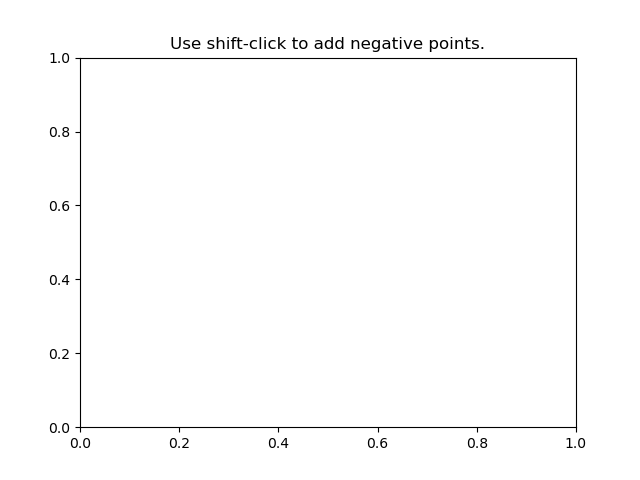

In [21]:
xTrain= np.array([[5,6],[2,5]])
yTrain = np.array([-1,1])
fig = plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)


def onclick_boost(event):
    """
    Visualize boosting, including new point
    """
    global xTrain,yTrain
    # create position vector for new point
    pos=np.array([[event.xdata,event.ydata]]) 
    if event.key == 'shift': # add positive point
        color='or'
        label=1
    else: # add negative point
        color='ob'
        label=-1    
    xTrain = np.concatenate((xTrain,pos), axis = 0)
    yTrain = np.append(yTrain, label)
    marker_symbols = ['o', 'x']
    classvals = np.unique(yTrain)
            
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    
    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(0,1,res)
    yrange = np.linspace(0,1,res)
    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T
    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T
    
    # get forest
    forest,alphas=boosttree(xTrain,yTrain,maxdepth=3,maxiter=5)
    if len(forest) > 0:
        fun = lambda X: evalforest(forest,X,alphas)
        # test all of these points on the grid
        testpreds = fun(xTe)

        # reshape it back together to make our grid
        Z = testpreds.reshape(res, res)
        Z[0,0] = 1 # optional: scale the colors correctly

        plt.cla()    
        plt.xlim((0,1))
        plt.ylim((0,1))
        # fill in the contours for these predictions
        plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)
    
    for idx, c in enumerate(classvals):
        plt.scatter(xTrain[yTrain == c,0],
            xTrain[yTrain == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    plt.show()
    
cid = fig.canvas.mpl_connect('button_press_event', onclick_boost)
plt.title('Use shift-click to add negative points.')

In [22]:
# Do not delete, copy, paste, or alter these cells as this will cause the tests to fail automatically

In [23]:
# Do not delete, copy, paste, or alter these cells as this will cause the tests to fail automatically

In [24]:
# Do not delete, copy, paste, or alter these cells as this will cause the tests to fail automatically

In [25]:
# Do not delete, copy, paste, or alter these cells as this will cause the tests to fail automatically

In [26]:
# Do not delete, copy, paste, or alter these cells as this will cause the tests to fail automatically

In [27]:
# Do not delete, copy, paste, or alter these cells as this will cause the tests to fail automatically

In [28]:
# Do not delete, copy, paste, or alter these cells as this will cause the tests to fail automatically

In [29]:
# Do not delete, copy, paste, or alter these cells as this will cause the tests to fail automatically

In [30]:
# Do not delete, copy, paste, or alter these cells as this will cause the tests to fail automatically

In [31]:
# Do not delete, copy, paste, or alter these cells as this will cause the tests to fail automatically

In [32]:
# Do not delete, copy, paste, or alter these cells as this will cause the tests to fail automatically

**Competition**: we ask you to improve the speed of evaltree and cart while keeping both functions accurate.
    
You will receive 3 points if your implemention as fast or faster than our slow solution on hidden data and 3 points if your implementation as fast or faster than our quick solution.

In [33]:
def u_points(ups):

    ups1 = np.arange(ups.shape[1]) 
    w = np.cumprod(ups1[:-1])
    w = np.insert(w, 0, 1)

    p_hashes = np.dot(ups, w)
    
    hashes, indices, inverse_i = np.unique(p_hashes, return_index=True, return_inverse=True)
    uv = ups[indices]
    
    return uv, inverse_i

def evaltreecomp(root,xTe,idx=[]):
    """Evaluates xTe using decision tree root.
    
    Input:
        root: TreeNode decision tree
        xTe:  n x d matrix of data points
    
    Output:
        pred: n-dimensional vector of predictions
    """

    assert root is not None
    
    # YOUR CODE HERE
    # raise NotImplementedError()

    xTe_u, indices = u_points(xTe)
    pred_u = np.zeros(xTe_u.shape[0])

    for i in range(xTe_u.shape[0]):
        myroot = root
        while True:
            if myroot.cutoff_id is None: 
                pred_u[i] = myroot.prediction
                break
            elif xTe_u[i,myroot.cutoff_id] <= myroot.cutoff_val:
                myroot = myroot.left
            else:
                myroot = myroot.right
    
    pred = pred_u[indices]
    print(pred.shape)
    return pred


def cartcomp(xTr,yTr,depth=np.inf,weights=None):
    """Builds a CART tree.
    
    The maximum tree depth is defined by "maxdepth" (maxdepth=2 means one split).
    Each example can be weighted with "weights".

    Args:
        xTr:      n x d matrix of data
        yTr:      n-dimensional vector
        maxdepth: maximum tree depth
        weights:  n-dimensional weight vector for data points

    Returns:
        tree: root of decision tree
    """
    n,d = xTr.shape
    if weights is None:
        w = np.ones(n) / float(n)
    else:
        w = weights
    
    # YOUR CODE HERE
    # raise NotImplementedError()

    tree = None

    prediction = np.dot(w, yTr) / np.sum(w)

    if depth == 0 or np.unique(yTr).size==1: #  n <=2 ???? or d <= 1: ????
        return TreeNode(None, None, None, None, None, prediction)

    feature, cut, loss = sqsplit(xTr, yTr, w)

    if feature == np.inf: 
        return TreeNode(None, None, None, None, None, prediction)
            
    l_i = xTr[:,feature] <= cut
    r_i = xTr[:,feature] > cut

    # if not np.any(l_i) or not np.any(r_i):
    #     return TreeNode(None, None, None, None, None, prediction)

    xl = xTr[l_i,:]
    yl = yTr[l_i]
    wl = w[l_i] # if weights is not None else None

    xr = xTr[r_i,:]
    yr = yTr[r_i]
    wr = w[r_i] # if weights is not None else None

    left_s = cartcomp(xl, yl, depth - 1, wl) # if np.any(l_i) else None
    right_s = cartcomp(xr, yr, depth - 1, wr) # if np.any(r_i) else None

    tree = TreeNode(left_s, right_s, None, feature, cut, None)
    if left_s is not None:
        left_s.parent = tree
    if right_s is not None:
        right_s.parent = tree
    # tree.prediction = (left_s.prediction + right_s.prediction)/2
    

    return tree

In [34]:
t0 = time.time()
root = cartcomp(xTrIon, yTrIon)
t1 = time.time()

repeat_factor = 20000
xTeIonRepeated = np.repeat(xTeIon, repeat_factor, axis = 0)

t2 = time.time()
pred = evaltreecomp(root,xTeIonRepeated)
t3 = time.time()

(1400000,)


In [35]:
# Do not delete, copy, paste, or alter these cells as this will cause the tests to fail automatically

In [36]:
# Do not delete, copy, paste, or alter these cells as this will cause the tests to fail automatically